In [1]:
# local version, copied from Eagle
# JLCY 2021-02-12

# based on: 
# /a2e-mmc/assessment/blob/master/examples/UsingTSLISToutput.ipynb

# developed on Mac WE42120

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime

obs_dir = '/Users/leec813/Documents/mmc/sgp/data/'
era_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/era5/'
gfs_wrf_all_dir = '/Users/leec813/Documents/mmc/sgp/data/gfs/'

# time step of wrf runs:
erad01_wrf_dt = 6
erad02_wrf_dt = 2
gfs_wrf_dt = 9

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(obs_dir+'data-dir-name.csv', index_col=0)

# obs
wp_winds_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
# wp_vstat_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

wp_winds = xr.open_mfdataset(wp_winds_ncs)
# wp_vstat = xr.open_mfdataset(wp_vstat_ncs)

toss_wp_data_below_height = 100

According to Rob Newsom, lidar data taken < 100 m need to be thrown out. 

In [2]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):
    
    # select data at few heights above threshold height
    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height))
                           .values[0:10])
    
    return [x for x in wp_height_list if str(x) != 'nan']

def plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_title): 

        lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
        lw = 1
        
        # reverse height list, useful for plotting
        wp_height_list = get_wp_height_list(wp_ds)[:len(lc_list)][::-1]

        for hgt, lc in enumerate(lc_list): 

            # slice of data at each height
            wrf_slice = wrf_ds.sel(height=wp_height_list[hgt])
            wp_slice = wp_ds.sel(height=wp_height_list[hgt])

            plt.plot(wrf_slice['datetime'], wrf_slice[wrf_var], 
                     label=str(np.round(wrf_slice['height'].values).astype(int))+' m', 
                     c=lc, linewidth=lw)
            plt.plot(wp_slice['time'], wp_slice[wp_var], c=lc, linewidth=lw, linestyle='--')

        plt.xticks(rotation='vertical')
        # 24 hours of data in plot
        plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
        plt.ylabel(var_title)
        
        plt.title(wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)
        plt.legend(title=wrf_run)
        
        plt.show()

def read_plot_obs_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    era_wrf_dir = era_wrf_all_dir+date_col['era']+'/'

    erad01_file_name = 'c1.d01'
    erad01_file_path = era_wrf_dir+erad01_file_name
    erad01_tower = Tower(erad01_file_path)

    erad02_file_name = 'c1.d02'
    erad02_file_path = era_wrf_dir+erad02_file_name
    erad02_tower = Tower(erad02_file_path)

    gfs_wrf_dir = gfs_wrf_all_dir+date_col['gfs']+'/'
    
    gfs_file_name = 'SGP.d01'
    gfs_file_path = '{}{}'.format(gfs_wrf_dir, gfs_file_name)
    gfs_tower = Tower(gfs_file_path)

    # simulation start time:
    # era & gfs runs have the same start times
    wrf_start = date_col['wrf_start']

    tower_list = [erad01_tower, erad02_tower, gfs_tower]
    dt_list = [erad01_wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    erad01_ds = read_tower_to_ds(erad01_tower, wrf_start, erad01_wrf_dt, wrf_height_list)
    erad02_ds = read_tower_to_ds(erad02_tower, wrf_start, erad02_wrf_dt, wrf_height_list)
    gfs_ds = read_tower_to_ds(gfs_tower, wrf_start, gfs_wrf_dt, wrf_height_list)
    
    wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}
    
    # for lidar only...
    var_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
    
    for wrf_var, var in var_dict.items():
        for wrf_run, wrf_ds in wrf_dict.items(): 
            plot_ts_at_wp_hgt(eval_date, wrf_run, wrf_ds, obs_ds, wrf_var, var[0], var[1])

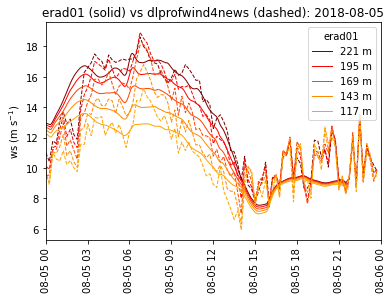

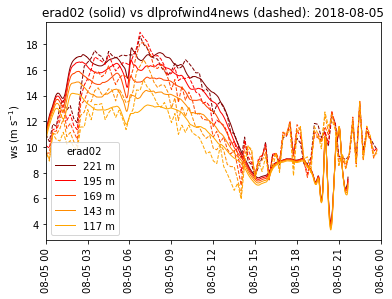

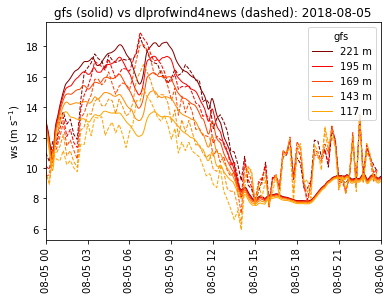

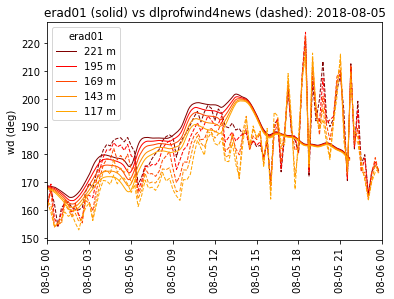

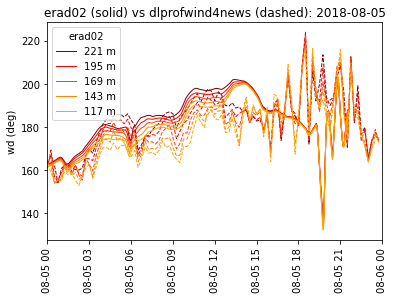

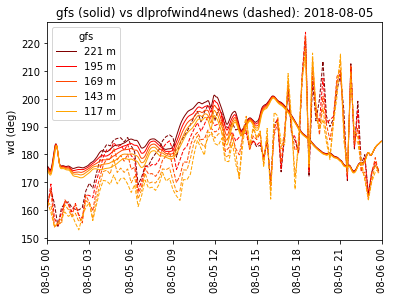

In [3]:
read_plot_obs_wrf_1day(wp_winds, '2018-08-05')

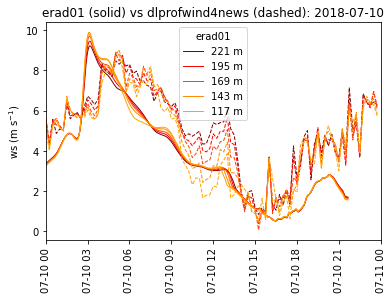

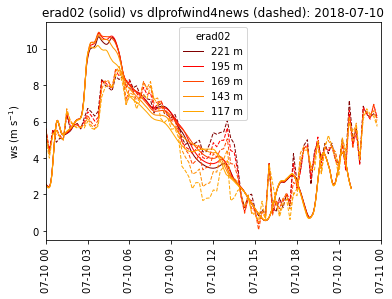

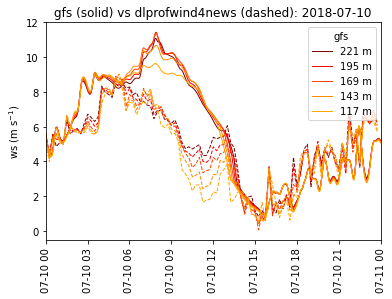

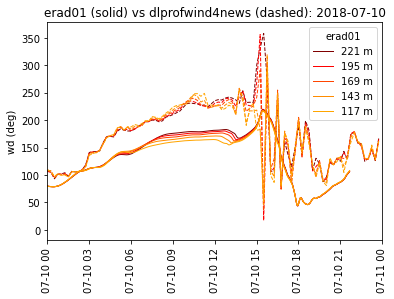

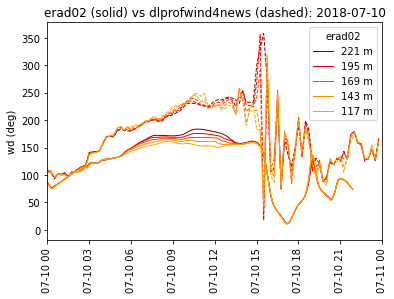

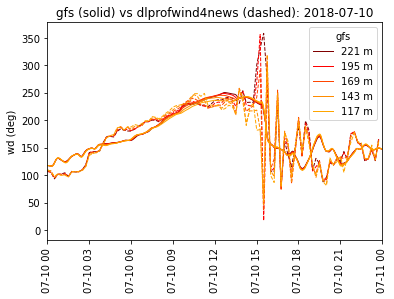

In [4]:
read_plot_obs_wrf_1day(wp_winds, '2018-07-10')

# obs

# wrf

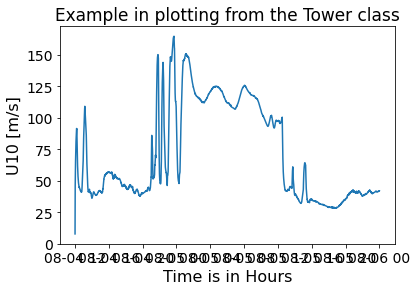

In [39]:
plt.plot(gfs_ds.datetime, gfs_ds.ws[:, 0])
plt.xlabel('Time is in Hours',size=16)
plt.ylabel('U10 [m/s]',size=16)
plt.tick_params(labelsize=14)
plt.title('Example in plotting from the Tower class',size=17)
plt.show()

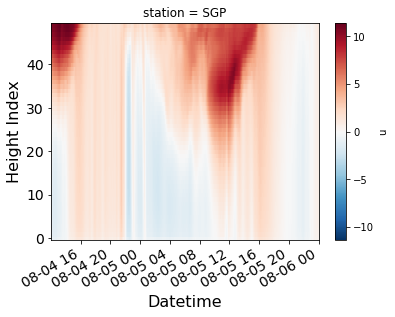

In [6]:
tower_ds.u.T.plot() # T is for 'transpose' since the first dimension will be put on the y-axis
plt.xlabel('Datetime',size=16)
plt.ylabel('Height Index',size=16)
plt.tick_params(labelsize=14)

# compare

220.83648681640625

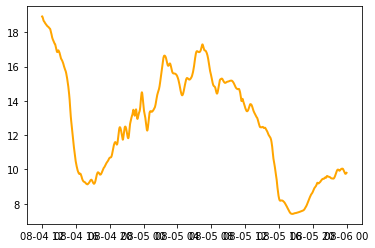

In [262]:
plt.plot(wrf_ds['datetime'], wrf_ds['ws'][:, hgt], label=str(round(wrf_ds.height.values[hgt]))+' m', 
                 c=lc, linewidth=lw)
wrf_ds.height.values[hgt]

In [265]:
gfs_ds

<xarray.Dataset>
Dimensions:   (datetime: 14400, height: 9, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-04T12:00:09 ... 2018-08-06
  * height    (height) float64 116.9 142.9 168.9 194.9 ... 272.8 298.8 324.8
  * station   (station) <U3 'SGP'
Data variables:
    qv        (datetime, height, station) float64 0.008534 0.008522 ... 0.00968
    theta     (datetime, height, station) float64 306.5 306.7 ... 311.6 311.6
    v         (datetime, height, station) float64 16.63 16.51 ... 9.751 9.752
    pr        (datetime, height, station) float64 9.017e+04 ... 8.829e+04
    w         (datetime, height, station) float64 -0.0287 -0.02902 ... 0.398
    u         (datetime, height, station) float64 9.19 9.467 ... 0.9917 0.9981
    i         (station) int64 126
    j         (station) int64 125
    lat       (station) float64 36.59
    lon       (station) float64 -97.47
    zsurface  (station) float64 311.6
    t2        (datetime, station) float64 297.8 297.8 297.8 ... 309.8 309.8
    q2        (datetime, station) float64 0.01013 0.01014 ... 0.00996 0.00996
    u10       (datetime, station) float64 -0.9135 -0.9175 ... 0.572 0.5719
    v10       (datetime, station) float64 5.996 5.927 5.815 ... 6.299 6.297
    psfc      (datetime, station) float64 9.786e+04 9.786e+04 ... 9.774e+04
    lwd       (datetime, station) float64 375.3 375.3 375.3 ... 422.8 422.8
    swd       (datetime, station) float64 24.99 24.99 24.99 ... 174.1 174.1
    hfx       (datetime, station) float64 -6.71 -22.86 -22.37 ... 19.02 19.04
    lfx       (datetime, station) float64 14.61 13.34 13.28 ... 51.33 51.33
    tsk       (datetime, station) float64 297.7 297.4 297.3 ... 310.2 310.2
    slttop    (datetime, station) float64 301.2 301.2 301.2 ... 309.0 309.0
    rainc     (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc    (datetime, station) float64 0.0 0.0 0.0 ... 0.3147 0.3147 0.3147
    clw       (datetime, station) float64 0.00273 0.00393 ... 0.0058 0.00581
    ws        (datetime, height, station) float64 19.0 19.03 ... 9.802 9.803
    wd        (datetime, height, station) float64 208.9 209.8 ... 185.8 185.8

In [280]:
gfs_ds.sel(datetime=slice(eval_date, parser.parse(eval_date)+datetime.timedelta(hours=1)))['ws'][0, :]

<xarray.DataArray 'ws' (height: 9, station: 1)>
array([[13.62552062],
       [13.62056989],
       [13.61403914],
       [13.60816405],
       [13.60139373],
       [13.59530274],
       [13.58918683],
       [13.58344397],
       [13.57830044]])
Coordinates:
    datetime  datetime64[ns] 2018-08-05
  * height    (height) float64 116.9 142.9 168.9 194.9 ... 272.8 298.8 324.8
  * station   (station) <U3 'SGP'

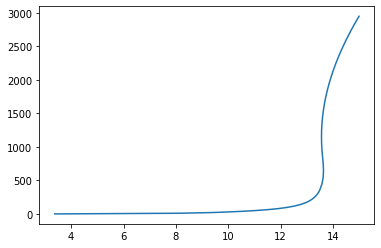

In [343]:
plt.plot(gfs_ds.sel(datetime=slice(eval_date, parser.parse(eval_date)+datetime.timedelta(hours=1)))['ws'][0, :], 
         gfs_ds['height'])

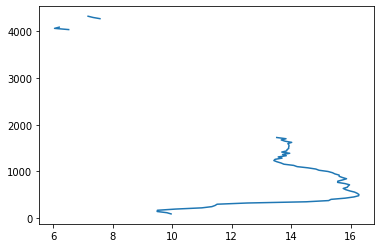

In [344]:
plt.plot(wp_winds_seg.sel(time=slice(eval_date, parser.parse(eval_date)+datetime.timedelta(hours=1)))['wind_speed'][0, :], 
         wp_winds_seg['height'])

In [337]:
wp_winds_seg

<xarray.Dataset>
Dimensions:               (bound: 2, height: 164, time: 96)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05T00:00:45.841247 .....
  * height                (height) float32 90.93 116.9 ... 4.3e+03 4.326e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(96,), meta=np.ndarray>
    u                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    u_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed            (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed_error      (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction        (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction_error  (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    residual              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    correlation           (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    mean_snr              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by user d

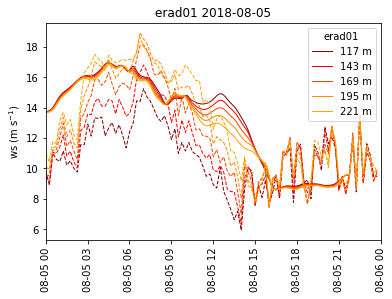

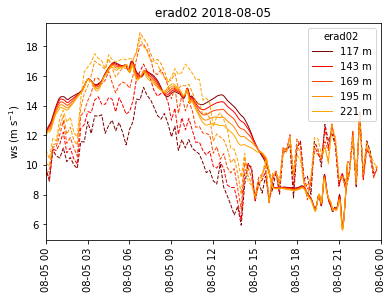

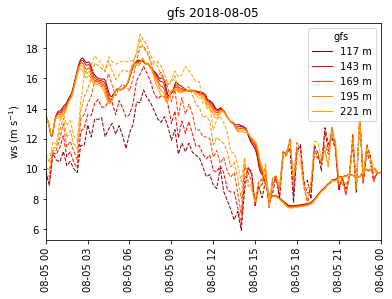

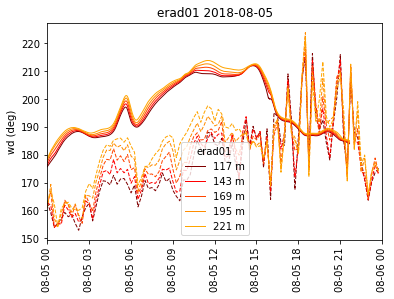

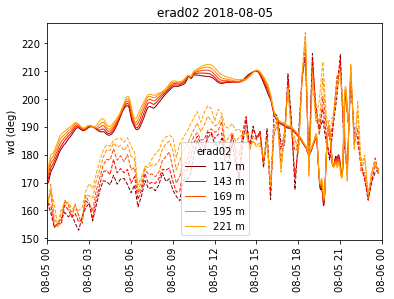

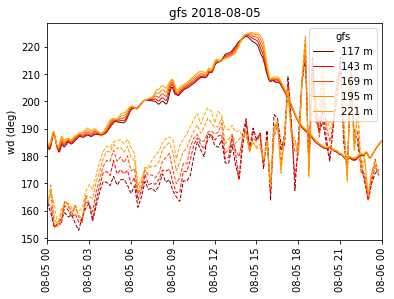

In [259]:
var_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
wrf_dict = {'erad01': erad01_ds, 'erad02': erad02_ds, 'gfs': gfs_ds}

def plot_ts_at_hgt(wrf_run, wrf_ds, obs_ds, wrf_var, obs_var, var_title): 

    lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    for hgt, lc in enumerate(lc_list): 

        plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var][:, hgt], label=str(round(wrf_ds.height.values[hgt]))+' m', 
                 c=lc, linewidth=lw)
        plt.plot(obs_ds['time'], obs_ds[obs_var].where(obs_ds.height == wrf_ds.height.values[hgt]), 
                 c=lc, linewidth=lw, linestyle='--')

    plt.xticks(rotation='vertical')
    plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    plt.ylabel(var_title)
    plt.title(wrf_run+' '+eval_date)
    plt.legend(title=wrf_run)
    plt.show()

for wrf_var, var in var_dict.items():
    for wrf_run, wrf_ds in wrf_dict.items(): 
        plot_ts_at_hgt(wrf_run, wrf_ds, wp_winds_seg, wrf_var, var[0], var[1])

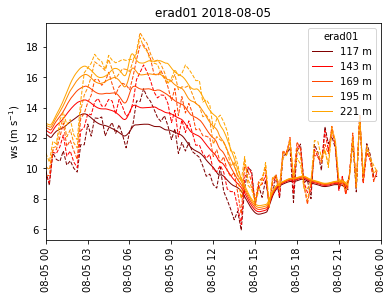

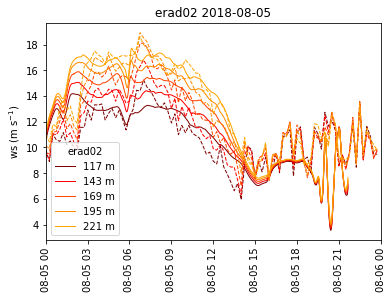

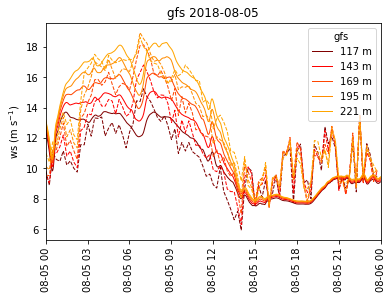

In [201]:
def plot_ts_at_hgt(wrf_run, wrf_ds, obs_ds): 

    lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    for hgt, lc in enumerate(lc_list): 

        plt.plot(wrf_ds['datetime'], wrf_ds['ws'][:, hgt], label=str(round(wrf_ds.height.values[hgt]))+' m', 
                 c=lc, linewidth=lw)
        plt.plot(obs_ds['time'], obs_ds.wind_speed.where(obs_ds.height == wrf_ds.height.values[hgt]), 
                 c=lc, linewidth=lw, linestyle='--')

    plt.xticks(rotation='vertical')
    plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    plt.ylabel(r'ws (m s$^{-1}$)')
    plt.title(wrf_run+' '+eval_date)
    plt.legend(title=wrf_run)
    plt.show()

for wrf_run, wrf_ds in wrf_dict.items(): 
    plot_ts_at_hgt(wrf_run, wrf_ds, wp_winds_seg)

In [153]:
gfs_ds.height.values[0]

116.91343688964844

In [156]:
str(round(gfs_ds.height.values[0]))+' m'

'117 m'

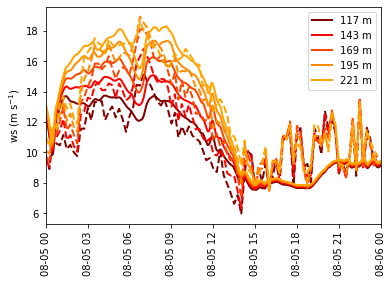

In [175]:
lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']

for hgt, lc in enumerate(lc_list): 

    plt.plot(gfs_ds['datetime'], gfs_ds['ws'][:, hgt], label=str(round(gfs_ds.height.values[hgt]))+' m', 
             c=lc, linewidth=lw)
    plt.plot(wp_winds_seg['time'], wp_winds_seg.wind_speed.where(wp_winds_seg.height == gfs_ds.height.values[hgt]), 
             c=lc, linewidth=lw, linestyle='--')

plt.xticks(rotation='vertical')
plt.xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()

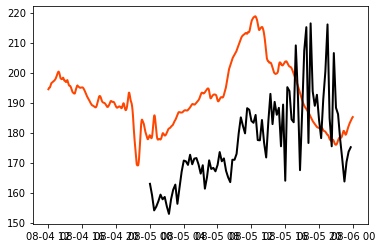

In [241]:
plt.plot(gfs_ds['datetime'], Dir[:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_direction'][:, 1], label='obs', c='k', linewidth=lw)

In [135]:
wp_winds_seg.wind_speed.where(wp_winds_seg.height == gfs_ds.height.values[0])

array([[       nan,  9.8192215,        nan, ...,        nan,        nan,
               nan],
       [       nan,  8.903505 ,        nan, ...,        nan,        nan,
               nan],
       [       nan, 11.012843 ,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, 10.917907 ,        nan, ...,        nan,        nan,
               nan],
       [       nan,  9.451756 ,        nan, ...,        nan,        nan,
               nan],
       [       nan,  9.482063 ,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

In [127]:
erad02_ds.height.values

array([116.91343689, 142.89419556, 168.87496948, 194.85572815,
       220.83648682, 246.81724548, 272.79800415, 298.77877808,
       324.759552  ])

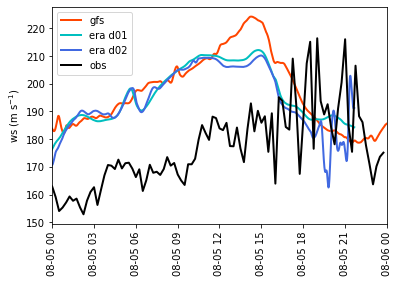

In [243]:
lw = 2
plt.plot(gfs_ds['datetime'], gfs_ds['wd'][:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(erad01_ds['datetime'], erad01_ds['wd'][:, 1], label='era d01', c='c', linewidth=lw)
plt.plot(erad02_ds['datetime'], erad02_ds['wd'][:, 1], label='era d02', c='royalblue', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_direction'][:, 1], label='obs', c='k', linewidth=lw)
plt.xticks(rotation='vertical')
plt.xlim(parser.parse('2018-08-05'), parser.parse('2018-08-06'))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()

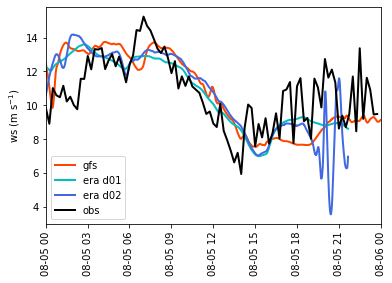

In [53]:
lw = 2
plt.plot(gfs_ds['datetime'], gfs_ds['ws'][:, 1], label='gfs', c='orangered', linewidth=lw)
plt.plot(erad01_ds['datetime'], erad01_ds['ws'][:, 1], label='era d01', c='c', linewidth=lw)
plt.plot(erad02_ds['datetime'], erad02_ds['ws'][:, 1], label='era d02', c='royalblue', linewidth=lw)
plt.plot(wp_winds_seg['time'], wp_winds_seg['wind_speed'][:, 1], label='obs', c='k', linewidth=lw)
plt.xticks(rotation='vertical')
plt.xlim(parser.parse('2018-08-05'), parser.parse('2018-08-06'))
plt.ylabel(r'ws (m s$^{-1}$)')
plt.legend()
plt.show()

In [60]:
np.where(np.round(wp_winds_seg['height'], 1) == 90.9)

(array([0]),)

In [81]:
wp_winds_seg.sel(height=91, method="nearest")

<xarray.Dataset>
Dimensions:               (bound: 2, time: 96)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05T00:00:45.841247 .....
    height                float32 90.93
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(96,), meta=np.ndarray>
    u                     (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    u_error               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    v                     (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    v_error               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    w                     (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    w_error               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    wind_speed            (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    wind_speed_error      (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    wind_direction        (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    wind_direction_error  (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    residual              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    correlation           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    mean_snr              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by user dsmgr on machine ruby at 2018-05-0...

In [92]:
test = wp_winds_seg.where(wp_winds_seg.height < 150.)

In [100]:
test['wind_speed'][:, 10].values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan], dtype=float32)

In [115]:
height_list = list(wp_winds_seg.height.where((wp_winds_seg.height > 100)).values[0:10])
height_list = [x for x in height_list if str(x) != 'nan']
height_list

[116.91344,
 142.8942,
 168.87497,
 194.85573,
 220.83649,
 246.81725,
 272.798,
 298.77878,
 324.75955]

In [64]:
wp_winds_seg

<xarray.Dataset>
Dimensions:               (bound: 2, height: 164, time: 96)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05T00:00:45.841247 .....
  * height                (height) float32 90.93 116.9 ... 4.3e+03 4.326e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(96,), meta=np.ndarray>
    u                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    u_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed            (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed_error      (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction        (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction_error  (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    residual              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    correlation           (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    mean_snr              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by user d

In [59]:
np.round(wp_winds_seg['height'], 1)

<xarray.DataArray 'height' (height: 164)>
array([  90.9,  116.9,  142.9,  168.9,  194.9,  220.8,  246.8,  272.8,
        298.8,  324.8,  350.7,  376.7,  402.7,  428.7,  454.7,  480.6,
        506.6,  532.6,  558.6,  584.6,  610.5,  636.5,  662.5,  688.5,
        714.5,  740.5,  766.4,  792.4,  818.4,  844.4,  870.4,  896.3,
        922.3,  948.3,  974.3, 1000.3, 1026.2, 1052.2, 1078.2, 1104.2,
       1130.2, 1156.1, 1182.1, 1208.1, 1234.1, 1260.1, 1286. , 1312. ,
       1338. , 1364. , 1390. , 1416. , 1441.9, 1467.9, 1493.9, 1519.9,
       1545.9, 1571.8, 1597.8, 1623.8, 1649.8, 1675.8, 1701.7, 1727.7,
       1753.7, 1779.7, 1805.7, 1831.6, 1857.6, 1883.6, 1909.6, 1935.6,
       1961.5, 1987.5, 2013.5, 2039.5, 2065.5, 2091.5, 2117.4, 2143.4,
       2169.4, 2195.4, 2221.4, 2247.3, 2273.3, 2299.3, 2325.3, 2351.3,
       2377.2, 2403.2, 2429.2, 2455.2, 2481.2, 2507.1, 2533.1, 2559.1,
       2585.1, 2611.1, 2637. , 2663. , 2689. , 2715. , 2741. , 2767. ,
       2792.9, 2818.9, 2844.9, 2870.9, 2896.9, 2922.8, 2948.8, 2974.8,
       3000.8, 3026.8, 3052.7, 3078.7, 3104.7, 3130.7, 3156.7, 3182.6,
       3208.6, 3234.6, 3260.6, 3286.6, 3312.5, 3338.5, 3364.5, 3390.5,
       3416.5, 3442.5, 3468.4, 3494.4, 3520.4, 3546.4, 3572.4, 3598.3,
       3624.3, 3650.3, 3676.3, 3702.3, 3728.2, 3754.2, 3780.2, 3806.2,
       3832.2, 3858.1, 3884.1, 3910.1, 3936.1, 3962.1, 3988. , 4014. ,
       4040. , 4066. , 4092. , 4118. , 4143.9, 4169.9, 4195.9, 4221.9,
       4247.9, 4273.8, 4299.8, 4325.8], dtype=float32)
Coordinates:
  * height   (height) float32 90.93 116.9 142.9 ... 4.274e+03 4.3e+03 4.326e+03
Attributes:
    long_name:      Height above ground level
    units:          m
    standard_name:  height